# LSTM 

In [1]:
import re 
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Gensim
import gensim
# # pytorch 
import torch
import torch.nn as nn
import torch.optim as optim

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clarissaache/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1160643473.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))
/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1160643473.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))


['use', 'model', 'system', 'study', 'method', 'propose', 'result', 'control', 'present', 'base', 'show', 'design', 'analysis', 'high', 'cell', 'data', 'also', 'patient', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'process', 'provide', 'new', 'paper', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'level', 'low', 'c_elsevier', 'power', 'measure', 'well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change']


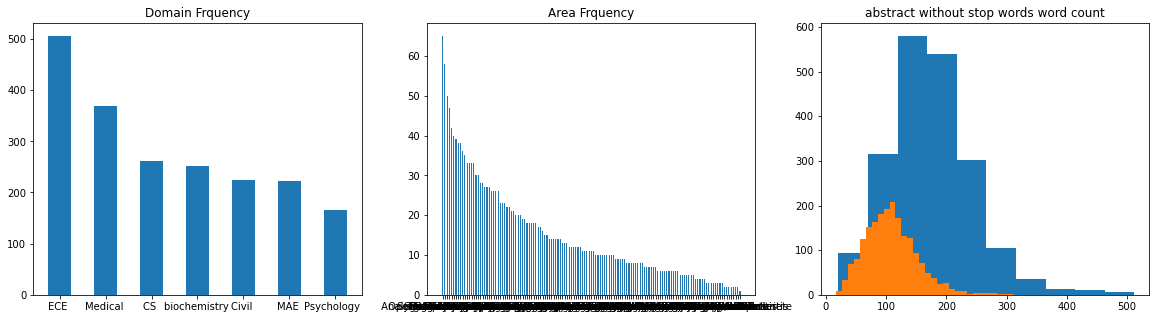

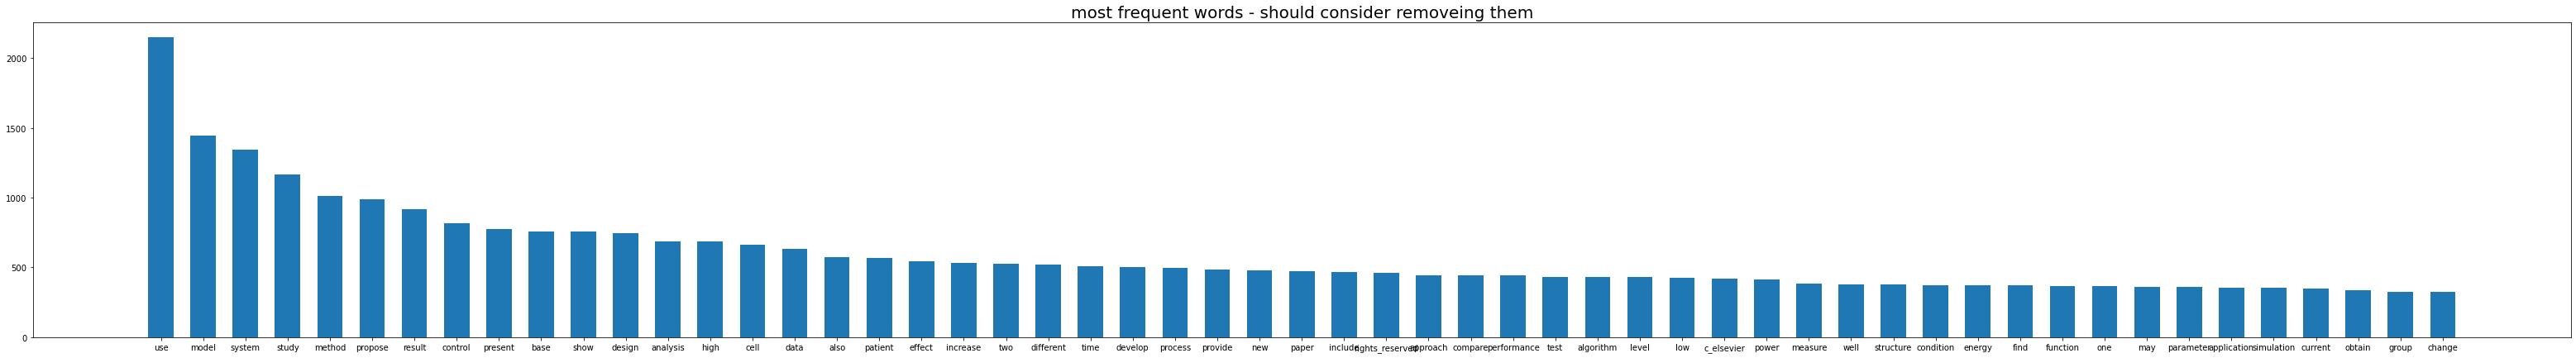

['well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change', 'frequency', 'dynamic', 'circuit', 'improve', 'expression']


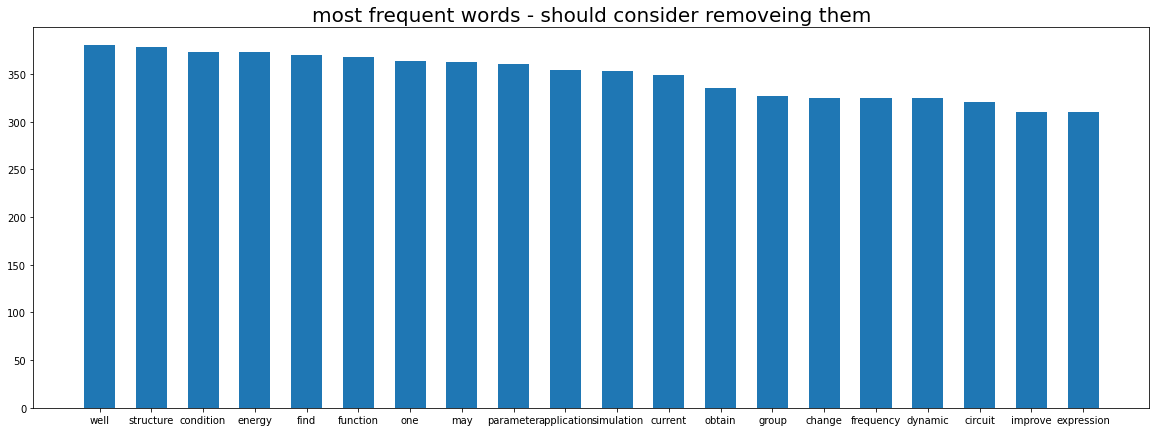

/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1160643473.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 91')

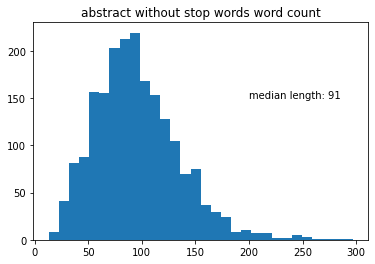

In [64]:
# USING THE SAME CODE FROM THE PROBABILITSTIC CLASSIFIER

# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())

# remove puncutations and number, then tokenize each text
text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,3,figsize=(20,5))
categories = df_paper.Domain.value_counts().index
counts = df_paper.Domain.value_counts().values
axs[0].bar(categories, counts, width=0.5)
axs[0].set_title("Domain Frquency")

categories = df_paper.area.value_counts().index
counts = df_paper.area.value_counts().values
axs[1].bar(categories, counts, width=0.5)
axs[1].set_title("Area Frquency")

axs[2].hist(df_paper.n_words)
axs[2].set_title("abstract word count")

# REMOVE STOP WORDS, MAKE BIGRAM, LEMMATIZE
import nltk
#nltk.download()

#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized

# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=20, threshold=50)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

abstract_lemmatized = prepare_token(text_tokenized)
df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

#  REMOVE FREQUENT WORDS

def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

# remove top 50 most frequent words
top_n = list(count_df[:40].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)

df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)

In [65]:
np.median(df_paper.n_words_lemmatize_clean)
abstract_lemmatized_cleaned[1] # list of lists
df_paper['abst_lemm_clnd']=abstract_lemmatized_cleaned
# Question for Shufan: Why does the 'df_paper' dataset not have the abstract_lemmatized_cleaned on it? nvm...
df_paper.sample(3)

/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1685861309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['abst_lemm_clnd']=abstract_lemmatized_cleaned


,Y1,Y2,Y,Domain,area,keywords,Abstract,n_words,n_words_removed,n_words_lemmatize_clean,abst_lemm_clnd
1019,1,7,24,ECE,Microcontroller,DC-DC converters; Photovoltaic cells; Solar e...,A novel microcontroller based maximum power po...,201,122,105,"[novel, microcontroller, maximum, point, track..."
1353,6,0,125,biochemistry,Molecular biology,multiwalled carbon nanotube; polyaniline; pla...,A simple and high sensitive cholesterol ampero...,134,86,78,"[simple, sensitive, cholesterol, amperometric,..."
1464,5,31,103,Medical,Low Testosterone,Bone mineral density; Hypogonadism; Klinefelt...,A Summary This manuscript describes the role o...,313,183,148,"[summary, manuscript, describes, role, vitamin..."


In [66]:
np.max(df_paper.n_words_lemmatize_clean)

297

In [67]:
from collections import Counter
counts = Counter()
for index, row in df_paper.iterrows():
    counts.update(row['abst_lemm_clnd'])

#they delete the infrequent words... we deleted the most frequent... That's okay


## Encoding

In [68]:
# We then create a vocabulary to index mapping and encode our abstract text using this mapping. 
# I’ve chosen the maximum length of any paper to be 300 words bc its the largest (we can change this)


# NO, SERIOUSLY, WHAT THE FUCK IS A VOCABULARY INDEX MAPPING??????????????????????


#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [69]:
def encode_sentence(text, vocab2index, N=300):
    tokenized = text
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

df_paper['encoded'] = df_paper['abst_lemm_clnd'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df_paper.head()

/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/2444801360.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_paper['encoded'] = df_paper['abst_lemm_clnd'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/2444801360.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['encoded'] = df_paper['abst_lemm_clnd'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


,Y1,Y2,Y,Domain,area,keywords,Abstract,n_words,n_words_removed,n_words_lemmatize_clean,abst_lemm_clnd,encoded
0,0,12,12,CS,Symbolic computation,(2+1)-dimensional non-linear optical waves; e...,(2 + 1)-dimensional non-linear optical waves t...,243,137,123,"[dimensional, nonlinear, optical, wave, cohere...","[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3..."
1,5,2,74,Medical,Alzheimer's Disease,Aging; Tau; Amyloid; PET; Alzheimer's disease...,(beta-amyloid (A beta) and tau pathology becom...,261,181,168,"[betaamyloid, beta, tau, pathology, become, in...","[[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, ..."
2,4,7,68,Civil,Green Building,LED lighting system; PV system; Distributed l...,(D)ecreasing of energy consumption and environ...,125,75,64,"[decrease, energy, consumption, environmentall...","[[61, 175, 176, 177, 178, 175, 179, 180, 181, ..."
3,1,10,26,ECE,Electric motor,NdFeB magnets; Electric motor; Electric vehic...,(Hybrid) electric vehicles are assumed to play...,143,91,84,"[hybrid, electric, vehicle, assume, play, majo...","[[225, 42, 226, 227, 228, 229, 230, 231, 232, ..."
4,5,43,115,Medical,Parkinson's Disease,Parkinson's disease; dyskinesia; adenosine A(...,"(L)-3,4-Dihydroxyphenylalanine ((L)-DOPA) rema...",206,129,123,"[ldihydroxyphenylalanine, ldopa, remain, prima...","[[281, 282, 86, 283, 284, 285, 286, 287, 288, ..."


In [70]:
df_paper['Domain'].unique()

array(['CS ', 'Medical ', 'Civil ', 'ECE ', 'biochemistry ', 'MAE ',
       'Psychology  '], dtype=object)

In [126]:
df_paper['encoded']
# I am not sure this is wrong

df_paper['Domain'].unique()

subs = {'CS ': np.array([1,0,0,0,0,0,0]), 'ECE ': np.array([0,1,0,0,0,0,0]), 'Civil ':np.array([0,0,1,0,0,0,0]), 'MAE ':np.array([0,0,0,1,0,0,0]) , 'Psychology  ':np.array([0,0,0,0,1,0,0]), 'biochemistry ':np.array([0,0,0,0,0,1,0]), 'Medical ':np.array([0,0,0,0,0,0,1])}
subs2 = {'CS ': 0, 'ECE ':1, 'Civil ':2, 'MAE ':3 , 'Psychology  ':4, 'biochemistry ':5, 'Medical ':6}

df_paper['domain'] = df_paper.Domain.map(subs)
df_paper['domain_int'] = df_paper.Domain.map(subs2)
df_paper['domain_int'].astype(int)
df_paper.sample(5)


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1745903870.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['domain'] = df_paper.Domain.map(subs)
/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1745903870.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['domain_int'] = df_paper.Domain.map(subs2)


,Y1,Y2,Y,Domain,area,keywords,Abstract,n_words,n_words_removed,n_words_lemmatize_clean,abst_lemm_clnd,encoded,domain,domain_int
1185,1,6,23,ECE,Electrical network,Datacenter; Bandwidth; Optical; Embedding; Vi...,A promising development in the design of datac...,217,128,114,"[promise, development, datacenters, hybrid, ne...","[[3348, 291, 15584, 225, 3034, 481, 855, 4, 30...","[0, 1, 0, 0, 0, 0, 0]",1
651,1,15,32,ECE,Operational amplifier,bandpass filter; operational amplifier; pole ...,A low component sensitivity band-pass filter h...,87,51,42,"[component, sensitivity, bandpass, filter, fil...","[[242, 961, 7154, 1191, 1191, 25, 4044, 748, 2...","[0, 1, 0, 0, 0, 0, 0]",1
685,2,14,47,Psychology,Child abuse,Child maltreatment; Child abuse and neglect; ...,A maternal history of childhood maltreatment i...,194,115,105,"[maternal, history, childhood, maltreatment, t...","[[1433, 2395, 2890, 7340, 1980, 694, 869, 211,...","[0, 0, 0, 0, 1, 0, 0]",4
1532,4,5,66,Civil,Suspension Bridge,Bridge; Aerodynamic derivatives; Numerical si...,A three-degrees of freedom (3-DOF) coupled num...,250,157,135,"[threedegrees, freedom, dof, couple, numerical...","[[18224, 8879, 9198, 16, 525, 526, 402, 12016,...","[0, 0, 1, 0, 0, 0, 0]",2
1225,4,4,65,Civil,Water Pollution,emergency control; emergency control paramete...,"A real-time, rapid emergency control (EC) mode...",195,121,98,"[realtime, rapid, emergency, ec, cope, sudden,...","[[340, 3107, 661, 4944, 6245, 8146, 656, 2102,...","[0, 0, 1, 0, 0, 0, 0]",2


In [127]:
X = list(df_paper['encoded'])
y = list(df_paper['domain_int'])

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [128]:
# no clue what this is doing...
from torch.utils.data import Dataset, DataLoader

class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [129]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [130]:
import torch.nn.functional as F

def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y = torch.tensor(y)
            print(y.shape) # print size of y
            print(type(y)) # print type of y
            y_pred = model(x, l)
            print(y_pred.shape)     #   print size of Y_pred
            print(type(y_pred))     #   print type of Y_pred
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 7 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [131]:
batch_size = 300
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [132]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 7)  # change from 5 to 7.. not sure why
        self.softmax = nn.Softmax()

    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [133]:
model = LSTM_variable_input(vocab_size, 50, 7)

In [134]:
train_model(model, epochs=30, lr=0.1)

/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
train loss 1.811, val loss 1.825, val accuracy 0.308, and val rmse 2.753
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
train loss 0.861, val loss 2.215, val accuracy 0.333, and val rmse 2.355
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
train loss 0.625, val loss 2.242, val accuracy 0.380, and val rmse 2.185
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
train loss 0.539, val loss 2.366, val accuracy 0.373, and val rmse 2.343
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>


/var/folders/wj/g21k_l5x5l95gccmpm_gvn0c0000gn/T/ipykernel_91087/1755169561.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([300])
<class 'torch.Tensor'>
torch.Size([300, 7])
<class 'torch.Tensor'>
torch.Size([100])
<class 'torch.Tensor'>
torch.Size([100, 7])
<class 'torch.Tensor'>
train loss 0.457, val loss 2.600, val accuracy 0.393, and val rmse 2.244
